In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
def fill_null(data):
    data_copy=data.copy()
    data_copy.drop(columns=['State Name','Dist Name'],inplace=True)
    data_copy=data_copy.interpolate(method='linear',limit_direction='forward')
    data_copy=data_copy.fillna(0)
    return data_copy

In [7]:
data_train_india=pd.read_csv("Participants_Data_GGSH_Solution_Notebook/India_train.csv")

In [8]:
print(data_train_india.shape)

(4705, 103)


In [9]:
data_train_india=fill_null(data_train_india)
print(data_train_india.shape)

(4705, 101)


In [10]:
#3 approaches 
#log distribution 
#cuberoot distribution
#cox distribution

#with all columns
#with imp columns

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
ssl=StandardScaler()
def get_with_importance(data):
    data_copy=data.copy()
    x=data_copy.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data_copy['COTTON YIELD (Kg per ha)']
    x=ssl.fit_transform(x)
    model=XGBRegressor()
    model.fit(x,y)
    feat_imp=model.feature_importances_
    return feat_imp


In [12]:
fimp=get_with_importance(data_train_india)
important_cols=[]
for i,j in zip(fimp,data_train_india.columns):
    if(i>=0.001 and j!='COTTON YIELD (Kg per ha)'):
        important_cols.append(j)
        print(i,j)

0.0021788452 COTTON AREA (1000 ha)
0.04043036 COTTON PRODUCTION (1000 tons)
0.0366041 APRIL PERCIPITATION (Millimeters)
0.0030253434 MAY PERCIPITATION (Millimeters)
0.004294051 JUNE PERCIPITATION (Millimeters)
0.005378406 SEPTEMBER PERCIPITATION (Millimeters)
0.00858894 OCTOBER PERCIPITATION (Millimeters)
0.001662245 DECEMBER PERCIPITATION (Millimeters)
0.00213034 JANUARY MINIMUM (Centigrate)
0.002551196 FEBRUARY MINIMUM (Centigrate)
0.0026171359 MARCH MINIMUM (Centigrate)
0.0010737008 APRIL MINIMUM (Centigrate)
0.003330222 JULY MINIMUM (Centigrate)
0.02131897 AUGUST MINIMUM (Centigrate)
0.00524836 SEPTEMBER MINIMUM (Centigrate)
0.003916265 DECEMBER MINIMUM (Centigrate)
0.0015436879 JANUARY MAXIMUM (Centigrate)
0.011150471 FEBRUARY MAXIMUM (Centigrate)
0.009157924 MARCH MAXIMUM (Centigrate)
0.0067011854 APRIL MAXIMUM (Centigrate)
0.004288305 MAY MAXIMUM (Centigrate)
0.0025506502 JUNE MAXIMUM (Centigrate)
0.0032103504 JULY MAXIMUM (Centigrate)
0.0027802568 SEPTEMBER MAXIMUM (Centigrate)

In [13]:
data_train_india2=data_train_india.copy()
important_cols.append('COTTON YIELD (Kg per ha)')
data_train_india2=data_train_india2.loc[:,important_cols]

In [14]:
print(data_train_india.shape)
print(data_train_india2.shape)

(4705, 101)
(4705, 73)


In [15]:
cols_to_norm=['COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)','MAY PERCIPITATION (Millimeters)','OCTOBER PERCIPITATION (Millimeters)','DECEMBER PERCIPITATION (Millimeters)','JUNE WATER DEFICIT (Millimeters)','AUGUST WATER DEFICIT (Millimeters)','MAY ACTUAL (Millimeters)','FOREST AREA (1000 ha)','BARREN AND UNCULTIVABLE LAND AREA (1000 ha)','CULTIVABLE WASTE LAND AREA (1000 ha)','OTHER FALLOW AREA (1000 ha)','NITROGEN CONSUMPTION (tons)','POTASH CONSUMPTION (tons)','COTTON YIELD (Kg per ha)']


In [130]:
from sklearn.preprocessing import FunctionTransformer
transformer=FunctionTransformer(np.cbrt)
def transforms(var):
    return np.log(10+var)
def transform_log(data):
    data_copy=data.copy()
    data_copy[cols_to_norm]=data_copy[cols_to_norm].apply(transforms)
    return data_copy
def cuberoot(data):
    data_cbrt=data.copy()
    data_cbrt[cols_to_norm]=transformer.transform(data_cbrt[cols_to_norm])
    return data_cbrt

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


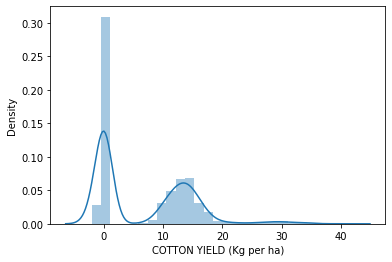

In [131]:
data_cbrt=cuberoot(data_train_india2)
sns.distplot(data_cbrt['COTTON YIELD (Kg per ha)'])
plt.show()


c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


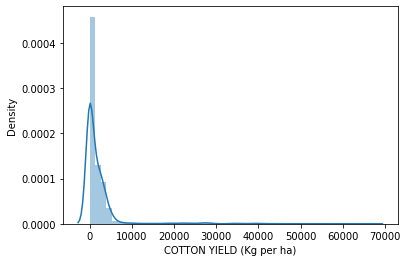

In [132]:
sns.distplot(data_train_india['COTTON YIELD (Kg per ha)'])
plt.show()

In [133]:
print(data_train_india2.shape)
print(data_cbrt.shape)

(4705, 73)
(4705, 73)


In [134]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
def baseline_model():
    model=Sequential()
    model.add(Dense(16,input_shape=(72,),kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [135]:
x=data_cbrt.drop(columns=['COTTON YIELD (Kg per ha)'])
y=data_cbrt['COTTON YIELD (Kg per ha)']
estimator=KerasRegressor(model=baseline_model,epochs=10,batch_size=35,verbose=0)
kfold=KFold(n_splits=10)
results=cross_val_score(estimator,x,y,cv=kfold,scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))

Baseline: -45.07 (9.88) MSE


In [136]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
x=data_cbrt.drop(columns=['COTTON YIELD (Kg per ha)'])
y=data_cbrt['COTTON YIELD (Kg per ha)']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
param_grid={'max_depth':[3,4,None]}
tree_model=GridSearchCV(DecisionTreeRegressor(random_state=0),cv=5,scoring='neg_mean_squared_error',param_grid=param_grid)
tree_model.fit(x_train,y_train)
predict_train=tree_model.predict(x_train)
predict_test=tree_model.predict(x_test)

In [140]:
new_feature=[]
for i in predict_train:
    new_feature.append(i)
for i in predict_test:
    new_feature.append(i)
print(len(new_feature))

4705


In [141]:
data_cbrt['new_feature']=new_feature

In [22]:
x=data_train_india2.drop(columns=['COTTON YIELD (Kg per ha)'])
y=data_train_india2['COTTON YIELD (Kg per ha)']
estimator=KerasRegressor(model=baseline_model,epochs=10,batch_size=35,verbose=0)
kfold=KFold(n_splits=10)
results=cross_val_score(estimator,x,y,cv=kfold,scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))

Baseline: -21045795.36 (10879955.81) MSE


In [97]:
def check_score(data):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    estimator=KerasRegressor(model=baseline_model,epochs=10,batch_size=35,verbose=0)
    kfold=KFold(n_splits=10)
    results=cross_val_score(estimator,x,y,cv=kfold,scoring='neg_mean_squared_error')
    print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))

In [24]:
data_3=data_train_india2.copy()
data_3['COTTON YIELD (Kg per ha)']=np.cbrt(data_3['COTTON YIELD (Kg per ha)'])
check_score(data_3)

Baseline: -57.29 (19.60) MSE


In [143]:
def larger_model():
    model=Sequential()
    model.add(Dense(16,input_shape=(73,),kernel_initializer='normal',activation='relu'))
    model.add(Dense(8,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [144]:
def wider_model():
    model=Sequential()
    model.add(Dense(24,input_shape=(73,),kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [145]:
def check_score_ssl(data):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    estimators=[]
    estimators.append(('standardize',StandardScaler()))
    estimators.append(('mlp',KerasRegressor(model=larger_model,epochs=50,batch_size=35,verbose=0)))
    pipeline=Pipeline(estimators)
    kfold=KFold(n_splits=10)
    results=cross_val_score(pipeline,x,y,cv=kfold,scoring='neg_mean_squared_error')
    print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))

In [146]:
check_score_ssl(data_cbrt)

Baseline: -10.17 (2.16) MSE


In [147]:
def check_score_ssl_wider(data):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    estimators=[]
    estimators.append(('standardize',StandardScaler()))
    estimators.append(('mlp',KerasRegressor(model=wider_model,epochs=50,batch_size=35,verbose=0)))
    pipeline=Pipeline(estimators)
    kfold=KFold(n_splits=10)
    results=cross_val_score(pipeline,x,y,cv=kfold,scoring='neg_mean_squared_error')
    print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))

In [148]:
check_score_ssl_wider(data_cbrt)

Baseline: -11.43 (2.25) MSE


In [161]:
def get_pred_ssl(data,data_test):
    x=data.drop(columns=['COTTON YIELD (Kg per ha)'])
    y=data['COTTON YIELD (Kg per ha)']
    x_test=data_test.drop(columns=['COTTON YIELD (Kg per ha)'])
    ssl=StandardScaler()
    x=ssl.fit_transform(x)
    #estimators=[]
    #estimators.append(('standardize',StandardScaler()))
    #estimators.append(('mlp',KerasRegressor(model=larger_model,epochs=50,batch_size=35,verbose=0)))
    #pipeline=Pipeline(estimators)
    #kfold=KFold(n_splits=10)
    #results=cross_val_score(pipeline,x,y,cv=kfold,scoring='neg_mean_squared_error')
    #print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))
    #preds=pipeline.fit_predict(x_test)
    model=larger_model()
    x_test=ssl.transform(x_test)
    model.fit(x,y,epochs=50,batch_size=35,verbose=False)
    prediction=model.predict(x_test)
    return prediction

In [162]:
data_india_test=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/India_test.csv')
data_test=fill_null(data_india_test)
data_test=data_test.loc[:,important_cols]
data_test_cbrt=cuberoot(data_test)

In [163]:
xtest=data_test_cbrt.drop(columns=['COTTON YIELD (Kg per ha)'])
test_newfeat=tree_model.predict(xtest)
data_test_cbrt['new_feature']=test_newfeat
predictions=get_pred_ssl(data_cbrt,data_test_cbrt)

In [164]:
len(predictions)

2476

In [165]:
predictions

array([[14.519128  ],
       [15.642382  ],
       [16.547426  ],
       ...,
       [ 0.70863837],
       [ 0.02936405],
       [ 1.1351163 ]], dtype=float32)

In [166]:
pred=[]
for i in range(0,2476):
    pred.append(predictions[i][0])

In [170]:
india_submission=[]
for i in pred:
    india_submission.append(np.power(i,3))
india_submission

[3060.7058112541704,
 3827.442146796923,
 4530.971812636711,
 3295.15948672306,
 8290.663205489695,
 7948.616569495571,
 4185.66202108366,
 4423.486110827334,
 1.6748157412914635,
 125.05315103292212,
 0.8253890783394436,
 0.03918649083871,
 15.828207046480877,
 28.71841946823565,
 960.0868231702848,
 0.49195978528626766,
 26.795925999884656,
 0.051811706102063836,
 -6.2315859101665385,
 -10.87605897485163,
 -1.9402274820465173,
 -27.3546533376557,
 -43.45775350915876,
 -3.0863544607888422,
 -4.489417651301944,
 -3.8096616100001577,
 -7.196989487945264,
 1003.5117168530664,
 0.5291001653247451,
 656.4266879415069,
 -2.8096054444282554,
 0.023478579540801257,
 4274.678557123299,
 7883.596828178172,
 3455.2030462294574,
 3030.88371123436,
 14489.008805290683,
 -0.7514304380533495,
 -5.116689862158732e-06,
 8660.397812631496,
 4604.082794794056,
 1900.3808367921647,
 17287.221539900453,
 3486.8782422293457,
 3514.4710919470317,
 12255.996918897772,
 6664.064617497784,
 2400.9194112205682,

In [168]:
def fill_null_usa(data):
    data_copy=data.copy()
    data_copy.drop(columns=['State','Planted (1000 Acres)','Harvested (1000 Acres)'],inplace=True)
    data_copy=data_copy.interpolate(method='linear',limit_direction='forward')
    data_copy=data_copy.fillna(0)
    return data_copy

In [169]:
data_train_usa=pd.read_csv("Participants_Data_GGSH_Solution_Notebook/USA_train.csv")
data_usa_train=fill_null_usa(data_train_usa)

In [38]:
len(data_usa_train.columns)

22

In [81]:
def larger_model_usa():
    model=Sequential()
    model.add(Dense(16,input_shape=(21,),kernel_initializer='normal',activation='relu'))
    model.add(Dense(8,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

def check_score_ssl_usa(data):
    x=data.drop(columns=['Yield (Pounds/ Harvested Area)'])
    y=data['Yield (Pounds/ Harvested Area)']
    estimators=[]
    estimators.append(('standardize',StandardScaler()))
    estimators.append(('mlp',KerasRegressor(model=larger_model_usa,epochs=100,batch_size=5,verbose=0)))
    pipeline=Pipeline(estimators)
    kfold=KFold(n_splits=10)
    results=cross_val_score(pipeline,x,y,cv=kfold,scoring='neg_mean_squared_error')
    print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))

In [82]:
check_score_ssl_usa(data_usa_train)

Baseline: -71560.60 (14828.15) MSE


In [49]:
def get_pred_usa_ssl(data,data_test):
    x=data.drop(columns=['Yield (Pounds/ Harvested Area)'])
    y=data['Yield (Pounds/ Harvested Area)']
    x_test=data_test.drop(columns=['Yield (Pounds/ Harvested Area)'])
    ssl=StandardScaler()
    x=ssl.fit_transform(x)
    #estimators=[]
    #estimators.append(('standardize',StandardScaler()))
    #estimators.append(('mlp',KerasRegressor(model=larger_model,epochs=50,batch_size=35,verbose=0)))
    #pipeline=Pipeline(estimators)
    #kfold=KFold(n_splits=10)
    #results=cross_val_score(pipeline,x,y,cv=kfold,scoring='neg_mean_squared_error')
    #print("Baseline: %.2f (%.2f) MSE" %(results.mean(),results.std()))
    #preds=pipeline.fit_predict(x_test)
    x_test=ssl.transform(x_test)
    model=larger_model_usa()
    model.fit(x,y,epochs=100,batch_size=5,verbose=False)
    prediction=model.predict(x_test)
    return prediction

In [50]:
data_test_usa=pd.read_csv("Participants_Data_GGSH_Solution_Notebook/USA_test.csv")
print(len(data_test_usa.columns))

25


In [51]:
data_test_usa=fill_null_usa(data_test_usa)

In [52]:
print(len(data_test_usa.columns))

22


In [53]:
predictions_usa=get_pred_usa_ssl(data_usa_train,data_test_usa)

In [54]:
predictions_usa

array([[ 723.8924  ],
       [ 445.54605 ],
       [ 903.3428  ],
       [ 644.78394 ],
       [ 738.3613  ],
       [ 601.6392  ],
       [ 179.91031 ],
       [ 513.5794  ],
       [ 308.25845 ],
       [ 555.12    ],
       [ 292.1704  ],
       [ 548.98737 ],
       [ 697.40717 ],
       [ 815.1762  ],
       [ 660.3386  ],
       [ 438.55347 ],
       [ 567.1612  ],
       [ 393.7044  ],
       [ 425.15854 ],
       [ 528.5876  ],
       [ 542.3409  ],
       [ 489.96506 ],
       [ 714.6342  ],
       [ 494.0616  ],
       [ 732.8817  ],
       [ 598.5401  ],
       [ 235.598   ],
       [ 296.32587 ],
       [ 510.39328 ],
       [ 749.0865  ],
       [ 348.32523 ],
       [ 616.21094 ],
       [ 487.91858 ],
       [ 336.42133 ],
       [ 325.04178 ],
       [ 526.8785  ],
       [ 528.531   ],
       [ 525.5077  ],
       [ 741.3375  ],
       [ 410.40842 ],
       [ 550.4084  ],
       [ 756.8421  ],
       [ 776.15594 ],
       [ 718.9403  ],
       [ 606.43884 ],
       [ 5

In [55]:
len(predictions_usa)

400

In [56]:
usa_submission=[]
for i in range(0,400):
    usa_submission.append(predictions_usa[i][0])

In [58]:
commodity=pd.read_csv('Participants_Data_GGSH_Solution_Notebook/USA_Commodity_prices.csv')
# Convert the 'Year' column to numeric type if it's not already
commodity['Year'] = pd.to_numeric(commodity['Year'])

# Select the rows between the years 2003 and 2022
submission_commodity = commodity[(commodity['Year'] >= 2003) & (commodity['Year'] <= 2022)]


In [59]:
submission_commodity=submission_commodity["Cotton_Price[Dollar/ton]"]

In [171]:
india=pd.DataFrame()
usa=pd.DataFrame()
india['COTTON YIELD (Kg per ha)']=india_submission
usa['Yield (Pounds/ Harvested Area)']=usa_submission

In [172]:
submission_india=india['COTTON YIELD (Kg per ha)']
submission_usa=usa['Yield (Pounds/ Harvested Area)']

In [173]:
final_submissions=pd.concat([submission_india,submission_usa,submission_commodity],axis=1)

In [174]:
final_submissions.head()

,COTTON YIELD (Kg per ha),Yield (Pounds/ Harvested Area),Cotton_Price[Dollar/ton]
0,3060.705811,723.892395,NaN
1,3827.442147,445.546051,NaN
2,4530.971813,903.342773,NaN
3,3295.159487,644.783936,NaN
4,8290.663205,738.361328,NaN


In [175]:
final_submissions=final_submissions.fillna(0)

In [71]:
final_submissions.to_csv("neural.csv",index=False)

In [176]:
final_cbrt=pd.read_csv('all_submissions\cbrt_submit.csv')

In [177]:
final_cbrt['COTTON YIELD (Kg per ha)']=india_submission

In [178]:
final_cbrt.to_csv("nn_decbrt.csv",index=False)

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


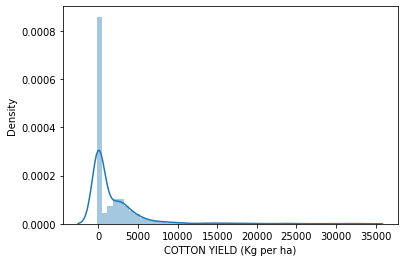

In [179]:
sns.distplot(final_submissions['COTTON YIELD (Kg per ha)'])
plt.show()

c:\Users\B Pranay\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


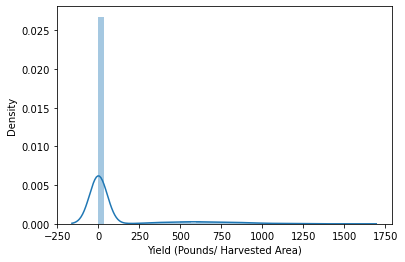

In [127]:
sns.distplot(final_submissions['Yield (Pounds/ Harvested Area)'])
plt.show()

In [128]:
data_test_usa['Yield (Pounds/ Harvested Area)'].value_counts()

0    400
Name: Yield (Pounds/ Harvested Area), dtype: int64

In [129]:
data_usa_test=pd.read_csv("Participants_Data_GGSH_Solution_Notebook/USA_test.csv")
data_usa_test['Yield (Pounds/ Harvested Area)'].value_counts()

0    400
Name: Yield (Pounds/ Harvested Area), dtype: int64